In [1]:
# Imports
import inspect
import random
import tempfile
import uuid
from functools import wraps
import collections
import seaborn as sns
import matplotlib.pyplot as plt
import coloredlogs
import dask as dd
import logging
import numpy as np
import pandas as pd
from coolname import generate_slug
import warnings

warnings.filterwarnings("ignore")


# Logger
logger = logging.getLogger(__name__)
coloredlogs.install(level="DEBUG")

# StackOverflow snippet #1
########################################################################################################################
# /////|   Decorator   |////////////////////////////////////////////////////////////////////////////////////////////////
########################################################################################################################


def auto_assign_arguments(function):
    @wraps(function)
    def wrapped(self, *args, **kwargs):
        _assign_args(self, list(args), kwargs, function)
        function(self, *args, **kwargs)

    return wrapped


########################################################################################################################
# /////|   Utils   |////////////////////////////////////////////////////////////////////////////////////////////////////
########################################################################################################################


def _assign_args(instance, args, kwargs, function):
    def set_attribute(instance, parameter, default_arg):
        if not (parameter.startswith("_")):
            setattr(instance, parameter, default_arg)

    def assign_keyword_defaults(parameters, defaults):
        for parameter, default_arg in zip(
            reversed(parameters), reversed(defaults)
        ):
            set_attribute(instance, parameter, default_arg)

    def assign_positional_args(parameters, args):
        for parameter, arg in zip(parameters, args.copy()):
            set_attribute(instance, parameter, arg)
            args.remove(arg)

    def assign_keyword_args(kwargs):
        for parameter, arg in kwargs.items():
            set_attribute(instance, parameter, arg)

    def assign_keyword_only_defaults(defaults):
        return assign_keyword_args(defaults)

    def assign_variable_args(parameter, args):
        set_attribute(instance, parameter, args)

    (
        POSITIONAL_PARAMS,
        VARIABLE_PARAM,
        _,
        KEYWORD_DEFAULTS,
        _,
        KEYWORD_ONLY_DEFAULTS,
        _,
    ) = inspect.getfullargspec(function)
    POSITIONAL_PARAMS = POSITIONAL_PARAMS[1:]  # remove 'self'

    if KEYWORD_DEFAULTS:
        assign_keyword_defaults(
            parameters=POSITIONAL_PARAMS, defaults=KEYWORD_DEFAULTS
        )
    if KEYWORD_ONLY_DEFAULTS:
        assign_keyword_only_defaults(defaults=KEYWORD_ONLY_DEFAULTS)
    if args:
        assign_positional_args(
            parameters=POSITIONAL_PARAMS, args=args
        )
    if kwargs:
        assign_keyword_args(kwargs=kwargs)
    if VARIABLE_PARAM:
        assign_variable_args(parameter=VARIABLE_PARAM, args=args)


########################################################################################################################

2019-12-11 15:48:28 siddharth-OptiPlex-7070 matplotlib.pyplot[23316] DEBUG Loaded backend module://ipykernel.pylab.backend_inline version unknown.


In [2]:
def generateGenome(NumberInsertionSites, NumberChromosomes):

    ###-----------Function main-----------###
    genome = list(range(1, NumberInsertionSites))
    InsertionSiteColumn = list(range(1, NumberInsertionSites))
    RecombinationRate = [0.01] * len(genome)
    chrLocation = np.random.choice(
        list(range(1, NumberInsertionSites - 10)),
        NumberChromosomes,
        replace=False,
    )
    SelectionCoef = np.random.normal(-0.02, 0.01, len(genome))
    insertionProbability = np.random.uniform(0.01, 0.99, len(genome))

    for i in chrLocation:
        RecombinationRate[i] = 0.5

    genomeDict = {
        "InsertionSiteID": InsertionSiteColumn,
        "InsertionProbability": insertionProbability,
        "RecombinationRate": RecombinationRate,
        "SelectionCoef": SelectionCoef,
    }
    genome = pd.DataFrame(genomeDict)

    ###-----------Function plot-----------###
    ### Plot the simulated variables
    sns.set(style="ticks", palette="muted", color_codes=True)
    # Set up the matplotlib figure
    f, axes = plt.subplots(1, 3, figsize=(15, 7))
    chartRecombinationRates = sns.distplot(
        RecombinationRate,
        ax=axes[0],
        kde=False,
        axlabel="Histogram - Recombination rate",
    )
    chartInsertionProbability = sns.distplot(
        insertionProbability,
        ax=axes[1],
        kde=False,
        axlabel="Histogram - Insertion probability",
    )
    chartSelectionCoef = sns.distplot(
        SelectionCoef,
        ax=axes[2],
        kde=False,
        axlabel="Histogram - Selection coefficient",
    )
    ###---------------Return--------------###
    return genome

In [46]:
########################################################################################################################
# /////|   Class   |////////////////////////////////////////////////////////////////////////////////////////////////////
########################################################################################################################
class initSim:
    """Class to initialize the progenitor (F0) population.

    initSim primarily creates an object which stores information about the 
    initial population. Moreover the inbuilt methods will return pandas
    dataframe for direct modification as desired.
    
    :return: Object
    :rtype: object type initSim
    """

    @auto_assign_arguments
    def __init__(
        self,
        tcount=1,
        ttype=[1],
        popsize=100,
        insize=2000,
        trate=[0.02],
        tparent=["Mother"],
        nChr=50,
    ):
        """Class constructor
        :param tcount: Number of transposons to be present in initial population
        :param ttype: Type of transposons (class 1 or 2)
        :param popsize: Population size
        :param insize: Number of insertion sites
        :param trate: Transposition rates
        :param tparent: Parent carrying the transposon insertion (Mother/Father)
        :param nChr: Number of chromosomes
        :type tcount: int
        :type ttype: list [int]
        :type popsize: int
        :type insize: int
        :type trate: list [float]
        :type tparent: list [string]
        :type nChr: int
        """
        # Dataframe definations
        self.TranspFrame = pd.DataFrame(
            columns=[
                "TID",
                "Name",
                "Class",
                "Traceback",
                "Generation",
                "Parent",
                "TraRate",
            ]
        )
        self.PopFrame = pd.DataFrame(
            columns=[
                "PID",
                "Fitness",
                "Name",
                "Sex",
                "Lineage",
                "Generation",
                "TEfather",
                "TEmother",
                "Insertion_Father",
                "Insertion_Mother",
            ]
        )
        self.GenFrame = pd.DataFrame(
            columns=[
                "InsertionSiteID",
                "InsertionProbability",
                "RecombinationRate",
                "SelectionCoef",
                "Filled",
            ]
        )

    # Init transposons
    def initT(self):
        """Method to dataframe containing initial transposon population
        
        :return: Dataframe containing Transposon information
        :rtype: Dataframe
        """
        if self.tcount > len(self.trate):
            logger.info(
                "Mismatch between transposon count and transposition rates. Using default for each transposon count!"
            )
            self.trate = [0.02] * self.tcount
        if self.tcount > len(self.ttype):
            logger.info(
                "Mismatch between transposon count and transposon types. Using default for each transposon count!"
            )
            self.ttype = [1] * self.tcount
        if self.tcount > len(self.tparent):
            logger.info(
                "Mismatch between transposon count and transposon parent. Using default for each transposon count!"
            )
            self.tparent = ["Mother"] * self.tcount

        # Create random filled insertion sites
        inSiteArray = random.sample(
            range(1, self.insize - 10), self.tcount
        )

        for i in range(0, self.tcount):
            row = pd.Series(
                {
                    "TID": uuid.uuid4().hex,
                    "InsertionSite": inSiteArray[i],
                    "TraRate": self.trate[i],
                    "Name": generate_slug(),
                    "Class": self.ttype[i],
                    "Traceback": ["0"],
                    "Generation": 1,
                    "Parent": self.tparent[i],
                }
            )
            self.TranspFrame = self.TranspFrame.append(
                row, ignore_index=True
            )
            self.TranspFrame["InsertionSite"] = self.TranspFrame[
                "InsertionSite"
            ].astype(int)
        return self.TranspFrame

    # Init population
    def initPG(self):
        """Method to create initial population and their respective genomes
        
        :return: tuple(population,genome)
            WHERE
            population is population dataframe
            genome is genome dataframe
        :rtype: DataFrame
        """

        # Create transposon insertions in randomly selected individuals
        IndividualToInsert = random.sample(
            list(range(1, self.popsize)), self.tcount
        )
        TIDlist = self.TranspFrame.TID.tolist()
        TIDcounter = 0
        Parent = "0"
        insertion_Father = 0
        insertion_Mother = 0
        FitnessPen = 0
        TEfather = "0"
        TEmother = "0"
        for i in range(self.popsize):
            # In case this (un)lucky individual has transposon insertion
            if i in IndividualToInsert:
                TE = TIDlist[TIDcounter]
                TIDcounter += 1
                insertionSiteID = self.TranspFrame[
                    self.TranspFrame["TID"] == TE
                ]["InsertionSite"].values[0]
                Parent = self.TranspFrame[
                    self.TranspFrame["TID"] == TE
                ]["Parent"].values[0]
                FitnessPen = self.GenFrame[
                    self.GenFrame["InsertionSiteID"]
                    == insertionSiteID
                ]["SelectionCoef"].values[0]
                print(FitnessPen)

                if Parent == "Mother":
                    insertion_Mother = self.TranspFrame[
                        self.TranspFrame["TID"] == TE
                    ]["InsertionSite"].values[0]
                    TEmother = TE

                if Parent == "Father":
                    insertion_Father = self.TranspFrame[
                        self.TranspFrame["TID"] == TE
                    ]["InsertionSite"].values[0]
                    TEfather = TE

            else:
                TE = "0"
                Parent = "0"
                insertion_Father = 0
                insertion_Mother = 0
                FitnessPen = 0
                TEmother = 0
                TEfather = 0

            # Populate the population!
            # Define intial fitness
            fitness = random.uniform(0.6, 1.0)
            rowPop = pd.Series(
                {
                    "PID": uuid.uuid4().hex,
                    "Fitness": fitness,
                    "NetFitness": fitness + FitnessPen,
                    "Name": generate_slug(),
                    "Sex": "H",
                    "Lineage": ["0"],
                    "Generation": 1,
                    "Insertion_Father": [insertion_Father],
                    "Insertion_Mother": [insertion_Mother],
                    "TEmother": [TEmother],
                    "TEfather": [TEfather],
                }
            )
            self.PopFrame = self.PopFrame.append(
                rowPop, ignore_index=True
            )

        self.PopFrame["Lineage"] = self.PopFrame["Lineage"].astype(
            "object"
        )
        self.PopFrame["Insertion_Father"] = self.PopFrame[
            "Insertion_Father"
        ].astype("object")
        self.PopFrame["Insertion_Mother"] = self.PopFrame[
            "Insertion_Mother"
        ].astype("object")
        return self.PopFrame

    def generateGenome(self):
        NumberInsertionSites = self.insize
        NumberChromosomes = self.nChr
        ###-----------Function main-----------###
        genome = list(range(1, NumberInsertionSites))
        InsertionSiteColumn = list(range(1, NumberInsertionSites))
        RecombinationRate = [0.01] * len(genome)
        chrLocation = np.random.choice(
            list(range(1, NumberInsertionSites - 10)),
            NumberChromosomes,
            replace=False,
        )
        SelectionCoef = np.random.normal(-0.02, 0.01, len(genome))
        insertionProbability = np.random.uniform(
            0.01, 0.99, len(genome)
        )

        for i in chrLocation:
            RecombinationRate[i] = 0.5

        TEoccStatus = [False] * len(genome)
        occupiedSites = self.TranspFrame["InsertionSite"].tolist()
        for i in occupiedSites:
            TEoccStatus[i-1] = True

        genomeDict = {
            "InsertionSiteID": InsertionSiteColumn,
            "InsertionProbability": insertionProbability,
            "RecombinationRate": RecombinationRate,
            "SelectionCoef": SelectionCoef,
            "Filled": TEoccStatus,
        }
        genome = pd.DataFrame(genomeDict)

        ###-----------Function plot-----------###
        ### Plot the simulated variables
        sns.set(style="ticks", palette="muted", color_codes=True)
        # Set up the matplotlib figure
        f, axes = plt.subplots(1, 3, figsize=(15, 7))
        chartRecombinationRates = sns.distplot(
            RecombinationRate,
            ax=axes[0],
            kde=False,
            axlabel="Histogram - Recombination rate",
        )
        chartInsertionProbability = sns.distplot(
            insertionProbability,
            ax=axes[1],
            kde=False,
            axlabel="Histogram - Insertion probability",
        )
        chartSelectionCoef = sns.distplot(
            SelectionCoef,
            ax=axes[2],
            kde=False,
            axlabel="Histogram - Selection coefficient",
        )
        ###---------------Return--------------###
        self.GenFrame = genome
        return genome

    def createSim(self):
        """Method to generate the initial simulation dataset
        
        :return: List
            WHERE 
            index 0 is transposon dataframe
            index 1 is population dataframe
            index 2 is genome dataframe
        :rtype: list
        """

        transposon = self.initT()
        genome = self.generateGenome()
        population = self.initPG()
        return [transposon, population, genome]


########################################################################################################################

In [4]:
def recombination(genomeFrame, genomeOrg):
    # Create insertion list for the progeny
    TEprogeny = []
    TEid = []
    # Create a copy of genomeFrame
    genomeCopy = genomeFrame.copy(deep=True)
    TEid_Father = genomeOrg["TEfather"].copy()
    TEid_Mother = genomeOrg["TEmother"].copy()
    Insertion_Father = genomeOrg["Insertion_Father"]
    Insertion_Mother = genomeOrg["Insertion_Mother"]
    if Insertion_Father[0] == 0 and Insertion_Mother[0] == 0:
        return (
            [0],
            random.choice(
                [
                    genomeOrg["Insertion_Father"],
                    genomeOrg["Insertion_Mother"],
                ]
            ),
        )
    else:
        initParent = random.choice(["M", "F"])
        surrogateParent = "M" if ("M" != initParent) else "F"
        RandArray = np.random.uniform(0, 1.0, genomeFrame.shape[0])
        switch = genomeCopy["RecombinationRate"] > RandArray
        # counter = collections.Counter(switch)
        # print(counter)
        genomeCopy["Progeny"] = np.where(
            switch.cumsum() % 2 == 0, initParent, surrogateParent
        )
        if all(v == 0 for v in Insertion_Father):
            pass
        else:
            for i in Insertion_Father:
                se = genomeCopy[genomeCopy["InsertionSite"] == i][
                    "Progeny"
                ].values[0]
                if se == "M":
                    TEprogeny.append(i)
                    TEid.append(TEid_Father.pop(0))
        if all(v == 0 for v in Insertion_Mother):
            pass
        else:
            for i in Insertion_Mother:
                se = genomeCopy[genomeCopy["InsertionSite"] == i][
                    "Progeny"
                ].values[0]
                if se == "F":
                    TEprogeny.append(i)
                    TEid.append(TEid_Mother.pop(0))
        # print(genomeCopy['Progeny'].value_counts())
    if not TEprogeny:
        TEprogeny.append(0)
    if not TEid:
        TEid.append(0)
    return (TEprogeny, TEid)

In [ ]:
def selection(
    transposonFrame, populationFrame, genomeFrame, generation
):
    parentFrame = populationFrame.sample(n=2, weights="NetFitness")
    fitness = (
        parentFrame.iloc[0]["Fitness"]
        + parentFrame.iloc[1]["Fitness"]
    ) / 2
    TIDm, alSetM = recombination(genome, parentFrame.iloc[0].copy())
    TIDf, alSetF = recombination(genome, parentFrame.iloc[1].copy())

    # Check for transposon and create a random insertion event
    if TIDm == [0] * len(TIDm):
        pass
    else:
        for i in TIDm:
            TranspositionRate = transposonFrame[
                transposonFrame["TID"] == i
            ]["TraRate"].values[0]
            TrpClass = transposonFrame[transposonFrame["TID"] == i][
                "Class"
            ].values[0]
            Trace = transposonFrame[transposonFrame["TID"] == i][
                "Traceback"
            ].values[0]
            Parent = "Father"
            insertionSite = random.choice(
                [
                    x
                    for x in list(range(1, insertionSites))
                    if x not in transposonFrame["Position"].tolist()
                ]
            )

            if -TranspositionRate > np.random.uniform(0, 1.0):
                row = pd.Series(
                    {
                        "TID": uuid.uuid4().hex,
                        "Position": insertionSite,
                        "TraRate": TranspositionRate,
                        "SelCo": np.random.normal(loc=-0.02, scale),
                        "Name": generate_slug(),
                        "Class": TrpClass,
                        "Traceback": Trace.append(i),
                        "Generation": generation,
                        "Parent": Parent,
                    }
                )
            self.TranspFrame = self.TranspFrame.append(
                row, ignore_index=True
            )

    # Check and create a random insertion event

    if x > np.random.uniform(0, 1.0):
        l = 1

    return rowPop

2019-12-11 16:15:20 siddharth-OptiPlex-7070 __main__[23316] INFO Mismatch between transposon count and transposition rates. Using default for each transposon count!
2019-12-11 16:15:20 siddharth-OptiPlex-7070 __main__[23316] INFO Mismatch between transposon count and transposon types. Using default for each transposon count!
2019-12-11 16:15:20 siddharth-OptiPlex-7070 __main__[23316] INFO Mismatch between transposon count and transposon parent. Using default for each transposon count!


-0.021227788572503268
-0.0019943622912781747
-0.031176248255033998
-0.010228482543925985


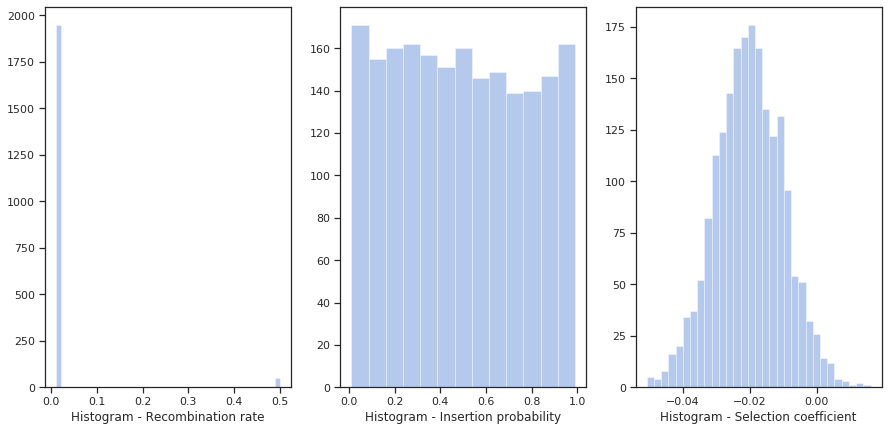

In [47]:
k = initSim(tcount=4)
k = k.createSim()

In [53]:
k[2]

,InsertionSiteID,InsertionProbability,RecombinationRate,SelectionCoef,Filled
0,1,0.862335,0.01,-0.030121,False
1,2,0.159121,0.01,-0.017988,False
2,3,0.919899,0.01,0.006365,False
3,4,0.644113,0.01,-0.031198,False
4,5,0.833529,0.01,-0.024105,False
...,...,...,...,...,...
1994,1995,0.791191,0.01,-0.023894,False
1995,1996,0.594411,0.01,-0.022863,False
1996,1997,0.742892,0.01,-0.024136,False
1997,1998,0.312848,0.01,-0.014804,False


In [48]:
k[0]

,TID,Name,Class,Traceback,Generation,Parent,TraRate,InsertionSite
0,b9d44127b17c45fd8b21244260b2f7c3,discreet-rugged-jaguar-of-endeavor,1,[0],1,Mother,0.02,933
1,b11a3472ae964082b5f7248f31f18811,quixotic-beige-moth-of-perspective,1,[0],1,Mother,0.02,1132
2,ea00b1da927c4e4588284fca26bd5578,lurking-modest-hyena-of-correction,1,[0],1,Mother,0.02,1808
3,7a6946100dff4871ad7491826a5dc46a,realistic-opalescent-lion-of-unity,1,[0],1,Mother,0.02,1498
